# Breast cancer clustering and classification with scikit-learn

This example uses the standard breast cancer dataset</a> from the UCI machine learning data repository. We train a k-nearest neighbors classifier using sci-kit learn and then explain the predictions.

In [268]:
import sklearn
import shap
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

from sklearn.datasets import load_breast_cancer


shap.initjs()

## Load the census data

In [492]:
# X,y = shap.datasets.adult()
# X_display,y_display = shap.datasets.adult(display=True)

X,y = load_breast_cancer(return_X_y=True)
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)



In [493]:
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=7)
#X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=7)

## Normalize the data before training the model

In [494]:
# normalize data
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
X_train_norm = X_train.copy()
X_valid_norm = X_valid.copy()
for k,dtype in dtypes:
    m = X_train[k].mean()
    s = X_train[k].std()
    X_train_norm[k] -= m
    X_train_norm[k] /= s
    
    X_valid_norm[k] -= m
    X_valid_norm[k] /= s

print(X_train.shape)

(455, 30)


# Visualize Data using the original labels

## Embed using t-SNE

In [449]:
def plot_samples(X_embedded, y_train, cluster_num):
    # define the colormap
    cmaplist = ['red', 'blue', 'green', 'orange', 'gray', 'purple', 'black', 'yellow', 'pink']

    
    color= [cmaplist[int(l) % cluster_num] for l in y_train]
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=color, s=3)

    plt.xlabel('x')
    plt.ylabel('y')

cluster_num = 2
X_embedded = TSNE(n_components=cluster_num).fit_transform(X_train)
print(X_embedded.shape)


(455, 2)


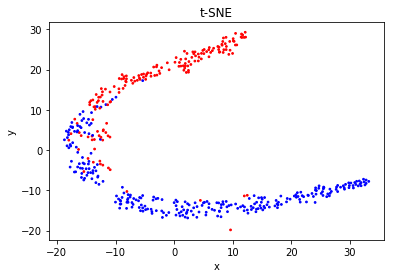

In [450]:
plot_samples(X_embedded, y_train, 2)
plt.title('t-SNE')
plt.show()

# K-Clustering

In [451]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

print(np.sum(pca.explained_variance_ratio_))

kmeans = KMeans(n_clusters=2, random_state=7).fit(X_train_pca)
y_train_pred = kmeans.predict(X_train_pca)
print(np.sum(kmeans.labels_))

0.9997890912390763
111


# Visualize Data using the clustering labels

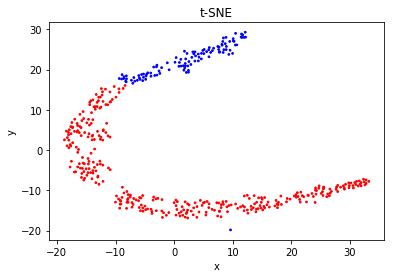

In [452]:
plot_samples(X_embedded, y_train_pred, 2)
plt.title('t-SNE')
plt.show()

# Explain using the Clustering Label

## Train a k-nearest neighbors classifier


In [487]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train_pca, y_train_pred)
f = lambda x: knn.predict_proba(pca.transform(x))[:,1]



### Explain predictions

Normally we would use a logit link function to allow the additive feature inputs to better map to the model's probabilistic output space, but knn's can produce infinite log odds ratios so we don't for this example.

It is important to note that 23(worst area) is the dominant feature in the 1000 predictions we explain. This is because it has larger variations in value than the other features and so it impacts the k-nearest neighbors calculations more.

In [489]:
# med = X_train.median().values.reshape((1,X_train.shape[1]))
# mean = X_train.mean()[None,:]
# print(type(med), type(mean))
X_rep = shap.kmeans(X_train, 10)
print(X_rep.data.shape)
explainer = shap.KernelExplainer(f, X_rep)
shap_values_single = explainer.shap_values(X.iloc[0,:], nsamples=1000)
shap.force_plot(shap_values_single, X_train)

(10, 30)


In [455]:
shap_values = explainer.shap_values(X_valid.iloc[:,:], nsamples=1000)
shap.force_plot(shap_values, X_valid.iloc[:,:])



  0%|          | 0/114 [00:00<?, ?it/s]

  1%|          | 1/114 [00:00<01:06,  1.69it/s]

  2%|▏         | 2/114 [00:01<01:05,  1.70it/s]

  3%|▎         | 3/114 [00:01<01:05,  1.70it/s]

  4%|▎         | 4/114 [00:02<01:03,  1.73it/s]

  4%|▍         | 5/114 [00:02<01:03,  1.73it/s]

  5%|▌         | 6/114 [00:03<01:02,  1.74it/s]

  6%|▌         | 7/114 [00:04<01:01,  1.74it/s]

  7%|▋         | 8/114 [00:04<01:01,  1.73it/s]

  8%|▊         | 9/114 [00:05<01:00,  1.73it/s]

  9%|▉         | 10/114 [00:05<00:59,  1.74it/s]

 10%|▉         | 11/114 [00:06<00:59,  1.74it/s]

 11%|█         | 12/114 [00:06<00:59,  1.73it/s]

 11%|█▏        | 13/114 [00:07<00:58,  1.72it/s]

 12%|█▏        | 14/114 [00:08<00:58,  1.72it/s]

 13%|█▎        | 15/114 [00:08<00:57,  1.72it/s]

 14%|█▍        | 16/114 [00:09<00:57,  1.71it/s]

 15%|█▍        | 17/114 [00:09<00:56,  1.71it/s]

 16%|█▌        | 18/114 [00:10<00:56,  1.71it/s]

 17%|█▋        | 19/114 [00:11<00:56,  1.69it/s]

 18%|█▊        |

A summary plot is an even better way to see the relative impact of all features over the entire dataset. Features are sorted by the sum of their SHAP value magnitudes across all samples.

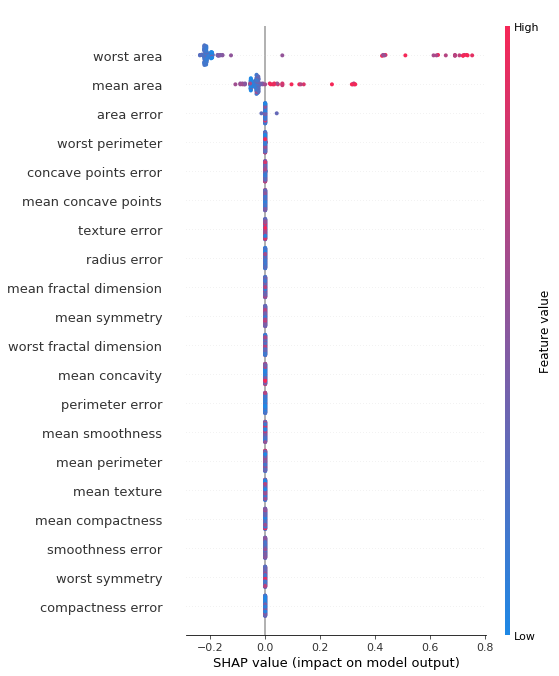

In [463]:
shap.summary_plot(shap_values, X_valid.iloc[:,:])

In [477]:
print(type(X_valid))

# Make prediction for the cluster membership of the testing points
y_valid_pred = knn.predict(pca.transform(X_valid))



    
# shap_values_by_cluster = [[] for _ in range(k)]
# clusters = [[] for _ in range(k)]
# for i in range(len(y_valid_pred)):
#     for j in range(k):
#         if y_valid_pred[i] == j:
#             shap_values_by_cluster[j].append(shap_values[i])
#             clusters[j].append(X_valid.iloc[i,:])

<class 'pandas.core.frame.DataFrame'>
   mean radius  mean texture  mean perimeter    mean area  mean smoothness  \
0    12.621702     18.607128       81.507234   502.064894         0.094971   
1    19.084500     21.598500      126.465000  1152.465000         0.102964   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0          0.088545        0.061753             0.034000       0.179727   
1          0.154687        0.177866             0.101154       0.197060   

   mean fractal dimension           ...             worst radius  \
0                0.063423           ...                  14.0585   
1                0.062057           ...                  23.7520   

   worst texture  worst perimeter   worst area  worst smoothness  \
0       24.47383        91.869574   621.771277          0.128939   
1       28.91250       159.160000  1758.450000          0.140875   

   worst compactness  worst concavity  worst concave points  worst symmetry  \
0           

## Cluster analysis

In [479]:
# Make prediction on the validation set
def aggregate(shap_values, X_valid, k, y_valid_pred):


    k = 2
    # Find the center points for the validation points for each cluster

    X_valid_centers = [[] for _ in range(k)]
    for j in range(k):
        X_valid_centers[j] = X_valid.loc[y_valid_pred==j].mean(axis=0)
    
    X_valid_centers = pd.concat(X_valid_centers, axis=1).transpose()

    # Aggregate Shapley values for each cluster by taking the average
    shap_values_by_cluster = [[] for _ in range(k)]

    for i in range(len(y_valid_pred)):
        for j in range(k):
            if y_valid_pred[i] == j:
                shap_values_by_cluster[j].append(shap_values[i])
    
    shap_value_for_cluster = []
    for j in range(k):
        shap_value_for_cluster.append(np.sum(shap_values_by_cluster[j], axis=0))

    shap_value_for_cluster = np.vstack(shap_value_for_cluster)

    return shap_value_for_cluster, X_valid_centers


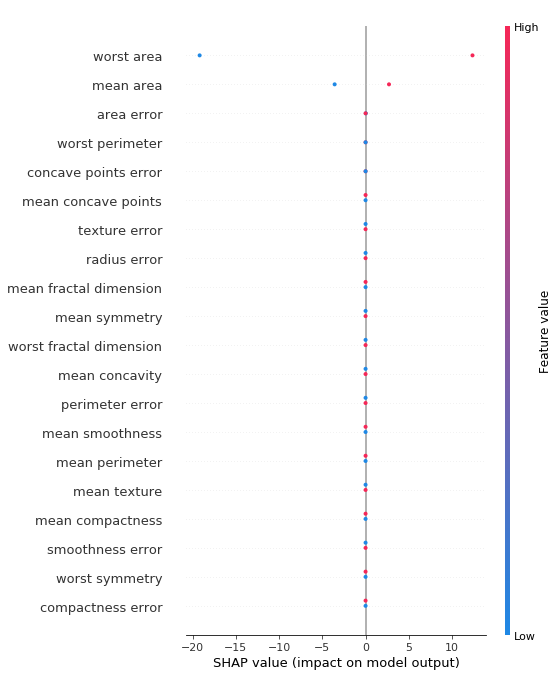

In [480]:
# Make prediction for the cluster membership of the testing points
y_valid_pred = knn.predict(pca.transform(X_valid))

shap_value_for_cluster, X_valid_centers = aggregate(shap_values, X_valid, 2, y_valid_pred)
shap.summary_plot(shap_value_for_cluster, X_valid_centers)

## Single Feature Analysis

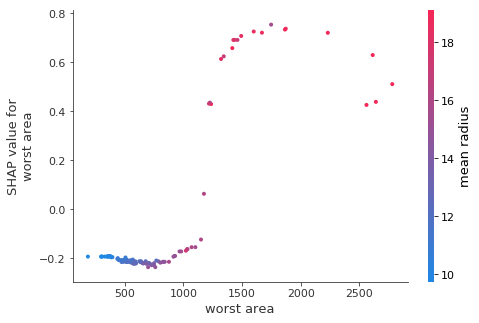

In [481]:
shap.dependence_plot(23, shap_values, X_valid.iloc[:,:])

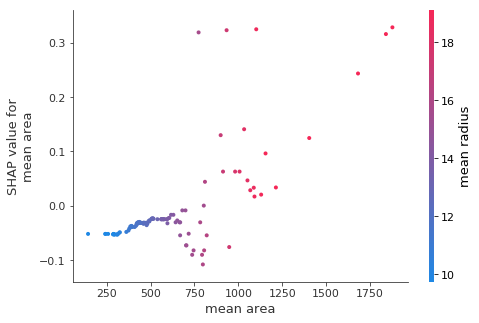

In [482]:
shap.dependence_plot(3, shap_values, X_valid.iloc[:,:])

# Explain using the Original Label

In [501]:
knn_original = sklearn.neighbors.KNeighborsClassifier()
knn_original.fit(X_train, y_train)
f_original = lambda x: knn_original.predict_proba(x)[:,1]

In [502]:
# med = X_train.median().values.reshape((1,X_train.shape[1]))

X_rep = shap.kmeans(X_train, 10)


explainer = shap.KernelExplainer(f_original, X_rep)
shap_values_single = explainer.shap_values(X.iloc[0,:], nsamples=1000)
shap.force_plot(shap_values_single, X_train)

In [503]:
shap_values_original = explainer.shap_values(X_valid.iloc[:,:], nsamples=1000)
shap.force_plot(shap_values_original, X_valid.iloc[:,:])



  0%|          | 0/114 [00:00<?, ?it/s]

  1%|          | 1/114 [00:00<01:10,  1.60it/s]

  2%|▏         | 2/114 [00:01<01:11,  1.56it/s]

  3%|▎         | 3/114 [00:01<01:10,  1.56it/s]

  4%|▎         | 4/114 [00:02<01:10,  1.56it/s]

  4%|▍         | 5/114 [00:03<01:09,  1.56it/s]

  5%|▌         | 6/114 [00:03<01:09,  1.56it/s]

  6%|▌         | 7/114 [00:04<01:09,  1.55it/s]

  7%|▋         | 8/114 [00:05<01:08,  1.55it/s]

  8%|▊         | 9/114 [00:05<01:07,  1.54it/s]

  9%|▉         | 10/114 [00:06<01:07,  1.54it/s]

 10%|▉         | 11/114 [00:07<01:06,  1.54it/s]

 11%|█         | 12/114 [00:07<01:05,  1.55it/s]

 11%|█▏        | 13/114 [00:08<01:05,  1.55it/s]

 12%|█▏        | 14/114 [00:09<01:04,  1.55it/s]

 13%|█▎        | 15/114 [00:09<01:03,  1.55it/s]

 14%|█▍        | 16/114 [00:10<01:03,  1.55it/s]

 15%|█▍        | 17/114 [00:10<01:02,  1.56it/s]

 16%|█▌        | 18/114 [00:11<01:01,  1.56it/s]

 17%|█▋        | 19/114 [00:12<01:00,  1.56it/s]

 18%|█▊        |

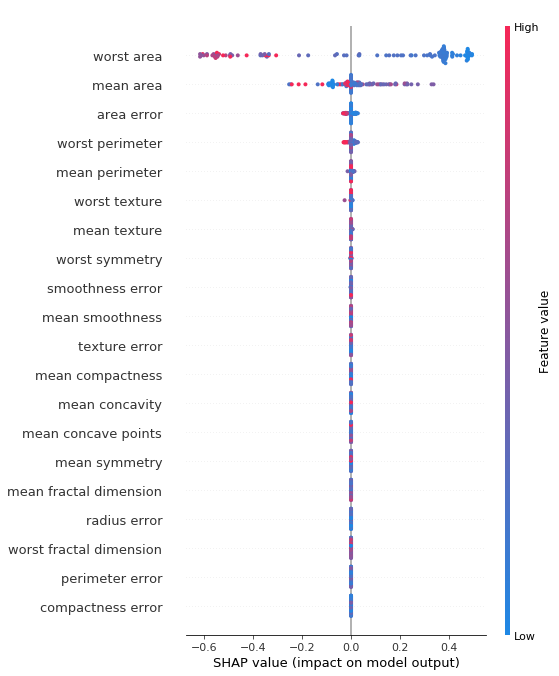

In [504]:
shap.summary_plot(shap_values_original, X_valid.iloc[:,:])

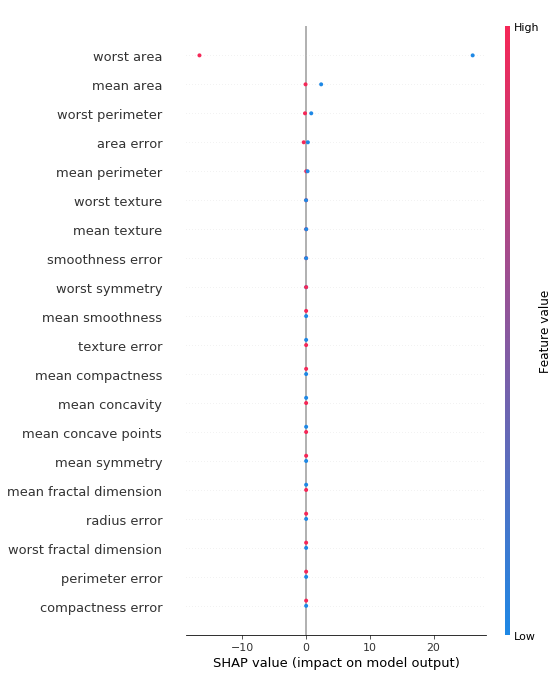

In [509]:
# Make prediction for the cluster membership of the testing points
y_valid_pred = knn_original.predict(X_valid)

shap_value_for_cluster, X_valid_centers = aggregate(shap_values_original, X_valid, 2, y_valid_pred)
shap.summary_plot(shap_value_for_cluster, X_valid_centers)

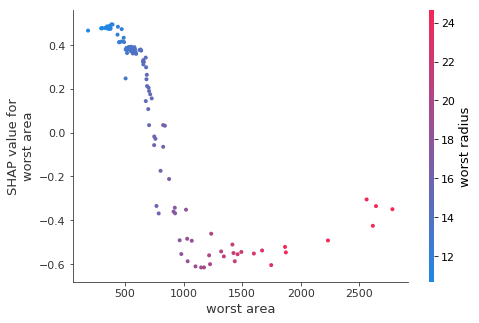

In [507]:
shap.dependence_plot(23, shap_values_original, X_valid.iloc[:,:])

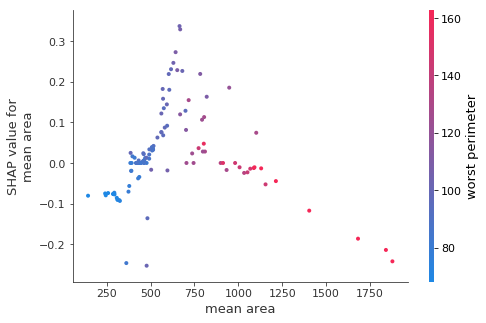

In [508]:
shap.dependence_plot(3, shap_values_original, X_valid.iloc[:,:])